In [35]:
import torch
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

In [36]:
trans = transforms.Compose([
    transforms.ToTensor(),  #it is like numpy array for pytorch  
    transforms.Normalize((0.5,), (0.5,))  #this normalizes the data between -1 and 1
])
#download the data
train_data = datasets.MNIST(
    root="./data",
    train=True,
    transform=trans,
)
test_data = datasets.MNIST(
    root="./data",
    transform=trans,
    train=False,
)
#print the length of the data
print(len(train_data))
print(len(test_data))


60000
10000


In [37]:
#split the data into train and validation using sklearn
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42, stratify=train_data.targets)
print(len(train_data))
print(len(val_data))

48000
12000


In [38]:
#load the data using dataloader
#what does data loder do?it loads the data in batches-it shuffles the data-it makes the data iterable
#what is the batch size?it is the number of samples that will be passed through the network at once
#what is shuffle?it shuffles the data so that the model will not learn the order of the data
batch_sz = 16
train_loader = DataLoader(train_data, batch_size=batch_sz, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_sz, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_sz, shuffle=True)

In [39]:
print(len(train_loader))
#750 is the number of batches it came from 48000(the length of the train dataset)/64=750 
print(len(val_loader))
#188 is the number of batches it came from 12000(the length of the validation dataset)/64=188
print(len(test_loader))
#157 is the number of batches it came from 10000(the length of the test dataset)/64=157

3000
750
625


In [40]:
import torch.nn as n
from torch import optim

In [41]:
class neural_model(n.Module):
    def __init__(self, lr):
        super().__init__()
        self.layers = n.Sequential(
            n.Flatten(),
            n.Linear(28 * 28, 400),  #input layer_input=28*28=784 output layer_input=200
            n.LayerNorm(400),  # Layer Normalization to speed up the training process
            n.Dropout(0.5),  #droping out the unwanted overfiting features
            n.Linear(400, 200),  #input h_layer_1=200 output h_layer_2=100
            n.ReLU(),
            n.Linear(200, 100),  #input h_layer_2=200 output h_layer_2=100
            n.ReLU(),
            n.Linear(100, 10),  #input output_layer=100 output output_layer=10
            n.LogSoftmax(dim=1)
        )
        self.loss = n.CrossEntropyLoss()
        self.learning_rate = lr
        self.optimizer = optim.SGD(self.parameters(), lr=self.learning_rate)

    def forward(self, x):
        x = self.layers(x)
        return x

    def fit(self, x, y):
        self.optimizer.zero_grad()  #this is to reset the gradients to zero
        y_output = self.forward(x)  #this is to get the predictions
        loss = self.loss(y_output, y)  #this is to get the loss
        loss.backward()  #this is to backpropagate the loss
        self.optimizer.step()  #this is to update the weights
        return loss.item()  #this is to return the loss

    def predict(self, x):
        with torch.no_grad():
            output = self.forward(x)
            _, predicted = torch.max(output, 1)
        return predicted



In [42]:
model = neural_model(0.01)

In [43]:
#train the model
epochs = 5
train_losses = []
val_losses = []
train_acc = []
val_acc = []
for epoch in range(epochs):
    train_loss = 0
    val_loss = 0
    train_accuracy = 0
    val_accuracy = 0
    model.eval()
    for x, y in train_loader:
        train_loss += model.fit(x, y)
        train_accuracy += torch.sum(model.predict(x) == y).item()

    train_losses.append(train_loss / len(train_loader))
    train_acc.append(train_accuracy / len(train_data))
    for x, y in val_loader:
        val_loss += model.fit(x, y)
        val_accuracy += torch.sum(model.predict(x) == y).item()
    val_losses.append(val_loss / len(val_loader))
    val_acc.append(val_accuracy / len(val_data))



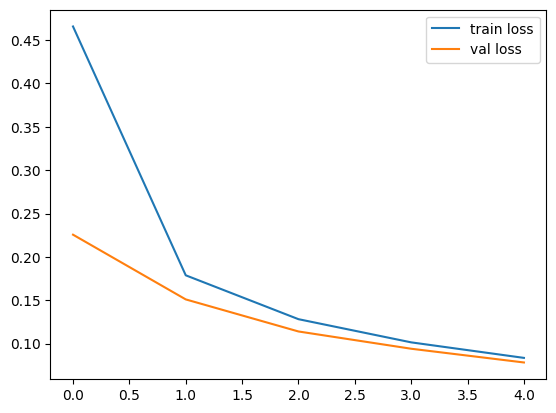

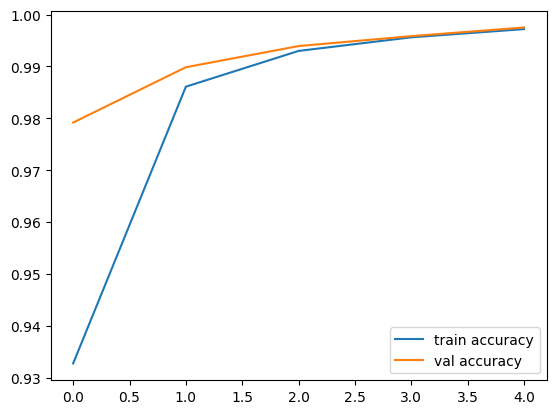

In [44]:
#plot the losses - the loss should decrease
#plot the accuracy - the accuracy should increase
import matplotlib.pyplot as plt

plt.plot(train_losses, label="train loss")
plt.plot(val_losses, label="val loss")
plt.legend()
plt.show()
plt.plot(train_acc, label="train accuracy")
plt.plot(val_acc, label="val accuracy")
plt.legend()
plt.show()

In [45]:
#get the accuracy and plot it
for x, y in train_loader:
    y_pred = model.predict(x)


In [46]:
learning_rates = [0.5, 0.05, 0.005, 0.0005, 0.00005]
batch_sizes = [20, 45, 85, 125, 280]
results = []

for lr in learning_rates:
    for b in batch_sizes:
        model = neural_model(lr)
        train_loss = 0
        val_loss = 0
        train_correct = 0
        val_correct = 0

        train_loader = DataLoader(train_data, batch_size=b, shuffle=True)
        val_loader = DataLoader(val_data, batch_size=b, shuffle=False)

        for x, y in train_loader:
            train_loss += model.fit(x, y)
            y_pred = model.predict(x)
            train_correct += torch.sum(y_pred == y).item()

        train_loss /= len(train_loader)
        train_accuracy = train_correct / len(train_data)

        model.eval()
        with torch.no_grad():
            for x_val, y_val in val_loader:
                output_val = model.forward(x_val)
                val_loss += model.loss(output_val, y_val).item()
                y_pred_val = model.predict(x_val)
                val_correct += torch.sum(y_pred_val == y_val).item()

            val_loss = val_loss / (len(val_loader)) * 100
            val_accuracy = (val_correct / len(val_data)) * 100

        results.append({
            'learning_rate': lr,
            'batch_size': b,
            'train_loss': train_loss,
            'train_accuracy': train_accuracy,
            'val_loss': val_loss,
            'val_accuracy': val_accuracy
        })

        print(f"lr: {lr}, batch size: {b}, train loss: {train_loss}, train accuracy: {train_accuracy} %")
        print(f"lr: {lr}, batch size: {b}, val loss: {val_loss}, val accuracy: {val_accuracy} %")
        print("-------------------------------------------------")


lr: 0.5, batch size: 20, train loss: 2.30835184743007, train accuracy: 0.14027083333333334 %
lr: 0.5, batch size: 20, val loss: 230.8818497657776, val accuracy: 11.233333333333333 %
-------------------------------------------------
lr: 0.5, batch size: 45, train loss: 2.3065839370166237, train accuracy: 0.1299375 %
lr: 0.5, batch size: 45, val loss: 230.20171636945744, val accuracy: 11.233333333333333 %
-------------------------------------------------
lr: 0.5, batch size: 85, train loss: 2.1548628347109906, train accuracy: 0.24575 %
lr: 0.5, batch size: 85, val loss: 130.1109167891489, val accuracy: 48.70833333333333 %
-------------------------------------------------
lr: 0.5, batch size: 125, train loss: 2.237191411977013, train accuracy: 0.2125 %
lr: 0.5, batch size: 125, val loss: 165.64986109733582, val accuracy: 35.775 %
-------------------------------------------------
lr: 0.5, batch size: 280, train loss: nan, train accuracy: 0.1275625 %
lr: 0.5, batch size: 280, val loss: nan,